In [3]:
from src.utils import *

In [2]:
# Load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.errors import TopologicalError
from unidecode import unidecode
import glob
import csv
from datetime import datetime
import dask.dataframe as dd
import dask_geopandas as dg
from dask.distributed import Client
import gc
import re

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_712376\2701944437.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [4]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
outdata_f = os.path.join(indata_f, 'OutputData', 'batch1')
if not os.path.exists(outdata_f):
    # Create the folder if it doesn't exist
    os.makedirs(outdata_f)

# 0 PREPARE A LOG FILE FOR QC
log_file = 'log_GQA_Step1.csv'
log_path = os.path.join(outdata_f, log_file)

# Initialize Dask client
client = Client()

# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}


In [5]:
# 1 READ URBAN CENTRES
# Read shapefile
uc_file_path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_Input.shp')
# Read the GeoPackage file
uc = gpd.read_file(uc_file_path)
uc['CNTR_CODE'].fillna('AA', inplace=True)

# Select cities for processing in this batch
uc_sel = uc.query('Batch==1.0')
# Read table to list the cities to process using urban centre code
cities_ls = uc_sel.HDENS_CLST.tolist()


In [6]:
# 2 READ NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')

# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])



In [7]:
# Read table with HDENS Urban centres information and Agglomerations link
HDENS_AGGL_tbl = pd.read_csv(r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\UrbanCentres_Agglomerations_csv.csv')
# Join uc code field to this table
HDENS_AGGL_tbl = HDENS_AGGL_tbl.merge(uc[['POPL_2021', 'HDENS_CLST']], on='POPL_2021')

In [228]:
HDENS_AGGL_tbl.head()

,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,agglomerationId_identifier,agglomerationName_nameEng,size,numberOfInhabitants,countryCode,Batch,HDENS_CLST
0,A Coruña,GEOSTAT11_610,282450,ES,AG_ES_11_15030,A Coruña,37.54,247046,ES,NaN,GEOSTAT21_610
1,Aachen,GEOSTAT11_360,224750,DE,AG_DE_NW_13,Aachen,161.00,246443,DE,NaN,GEOSTAT21_360
2,Aalborg,GEOSTAT11_031,149041,DK,AG_DK_00_4,Aalborg,66.00,138581,DK,1.0,GEOSTAT21_031
3,Aguadulce / La Gangosa,,55615,ES,AG_ES_61_04079,Roquetas de Mar,20.82,106147,ES,NaN,GEOSTAT21_960
4,Aix-en-Provence,GEOSTAT11_676,101708,FR,AG_FR_00_23,Marseille,3149.22,1886800,FR,NaN,GEOSTAT21_676


In [229]:
uc_sel.head()

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
0,GEOSTAT21_018,Stockholm,GEOSTAT11_018,1462910.0,SE,1,342000000.0,162000.0,1.0,"POLYGON ((4775000.000 4038000.000, 4774000.000..."
3,GEOSTAT21_021,Tartu,GEOSTAT11_021,84168.0,EE,2,24000000.0,24000.0,1.0,"POLYGON ((5292000.000 4030000.000, 5290000.000..."
5,GEOSTAT21_023,Stavanger,GEOSTAT11_023,196314.0,NO,9,78000000.0,74000.0,1.0,"POLYGON ((4074000.000 3976000.000, 4073000.000..."
6,GEOSTAT21_024,Norrköping,GEOSTAT11_024,89963.0,SE,1,25000000.0,28000.0,1.0,"POLYGON ((4684000.000 3955000.000, 4683000.000..."
7,GEOSTAT21_025,Linköping,GEOSTAT11_025,98073.0,SE,1,30000000.0,32000.0,1.0,"POLYGON ((4655000.000 3932000.000, 4653000.000..."


In [9]:
uc_sel.query("HDENS_NAME=='Bordeaux'")

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
490,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,1.0,"POLYGON ((3487000.000 2464000.000, 3486000.000..."


In [10]:
counter= 1
agl_error_ls = []

cities_ls=['GEOSTAT21_595']

# Loop through test cities
for uc_city_code in cities_ls:
    print(counter)
    start_time = datetime.now()
    print(str(start_time))

    HDENS_AGGL_city = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}'")
    agl_id_city_ls = HDENS_AGGL_city.agglomerationId_identifier.values.astype(str).tolist()
    for agl_id in agl_id_city_ls:
        HDENS_AGGL_city_aglid = HDENS_AGGL_tbl.query(f"HDENS_CLST=='{uc_city_code}' & agglomerationId_identifier=='{agl_id}'")
        ctry_code = HDENS_AGGL_city_aglid.CNTR_CODE.values.astype(str)[0]
        aglo_name = HDENS_AGGL_city_aglid.agglomerationName_nameEng.values.astype(str)[0]
        city_agl_cd = f"{ctry_code}-{uc_city_code}-{agl_id}-{aglo_name}"
        print(city_agl_cd)
        if len(ctry_code.split('-'))>1:
               print('>1 countries')
               agl_error_ls.append(city_agl_cd + " bordering countries")
        else:
            print('1 country for this urban centre')      
            # Load agglomeration boundary for selected city
            agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')
            if agl_city.empty:
                agglomerationId_identifier = 'NotAvailable'
                print ("agglomerationId_identifier Not Available")
                agl_error_ls.append(city_agl_cd + " agglomerationId_identifier Not Available")
            else:
                output_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                if not os.path.exists(output_path):
                    try:
                        # Check noise contour maps GeoPackage file
                        ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')
                        layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
                        #ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export_{ctry_code}.gpkg')
                        #layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'
                        #layerName = f'dbodf48_agg_noisecontours_roadsinagglomeration_lden_valid_latestdelivery_poly_{ctry_code}'
                        ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                                            engine='pyogrio', use_arrow=True, bbox= tuple(agl_city.total_bounds))
                        print ("ncm")

                        # Perform spatial overlay (intersection) 
                        ncm_agl = gpd.overlay(ncm, agl_city, how='intersection')
                        print ("ncm_agl")

                        # Aggregate the area with lower band values (quieter bands)
                        ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
                        ncm_agl_city.category.fillna(0)

                        # Select a subset of columns of interest
                        ncm_dis = ncm_agl_city[['category', 'geometry']]
                        
                        # Define the list of noisy classes
                        noisy_classes = ['Lden5559', 'Lden6064', 'Lden6569', 'Lden7074', 'LdenGreaterThan75']

                        # Create a condition based on the category column
                        condition = ncm_dis['category'].isin(noisy_classes)  # Replace 'category_column' with the actual column name

                        # Specify the condition and create a new category column based on the condition
                        ncm_dis['noisy'] = 0
                        ncm_dis.loc[condition, 'noisy'] = 1
                        ncm_dis = ncm_dis[['noisy', 'geometry']]
                        ncm_dis_dg = dg.from_geopandas(ncm_dis, npartitions=10)
                        ncm_dis = ncm_dis_dg.dissolve(by='noisy').compute().reset_index()
                        print ("ncm_dis")

                        # 3 READ UA DATA        
                        # Load GeoPackage info
                        data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
                        uc_city = uc_sel.query(f'HDENS_CLST == "{uc_city_code}"')
                        city_unicodeName_upper = unidecode(aglo_name).upper()
                        folder_path = glob.glob(os.path.join(data_f, f'{ctry_code}*{city_unicodeName_upper}*'))
                        ua_file_path =  glob.glob(os.path.join(folder_path[0], 'Data', f'{ctry_code}*{city_unicodeName_upper}*.gpkg'))
                        layers_ls = fiona.listlayers(ua_file_path[0])
                        print ("layers_ls")

                        # Read the GeoPackage file
                        ua = gpd.read_file(ua_file_path[0], layer= layers_ls[0], 
                                        columns= ['country', 'fua_name', 'fua_code','code_2018', 'class_2018', 'geometry'], engine='pyogrio', 
                                        use_arrow=True, bbox= tuple(uc_city.total_bounds))
                        print ("loaded ua in urban city")

                        # Select 'green' classes
                        uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
                        
                        # 4 SELECT UA INTERSECTING UC
                        # Perform spatial overlay (intersection)
                        uagreen_urbc = gpd.overlay(uagreen, uc_city, how='intersection')

                        # 5 IDENTIFY GREEN AREAS EXCLUDED (NOT COVERED BY NCM)
                        # Perform spatial overlay (intersection)
                        nqgreen = gpd.overlay(uagreen_urbc, ncm_dis, how='intersection') #noisy/quiet green
                        not_covered = uagreen_urbc.geometry.difference(uagreen_urbc.geometry.intersection(nqgreen.geometry.unary_union))
                        # Filter out empty polygons(not empty polygons)
                        green_not_covered_by_ncm = not_covered[~not_covered.is_empty]

                        # save to shapefile
                        file_path = os.path.join(outdata_f, f'{city_agl_cd}_green_not_covered_by_ncm.shp')
                        green_not_covered_by_ncm.to_file(file_path, driver='ESRI Shapefile')
                        print ("green_not_covered_by_ncm")

                        # 6 IDENTIFY QUIET/NOISY AREAS
                        ## for statistics need to calculate area again
                        # Calculate the area for each geometry and create a new column 'area'
                        nqgreen['area_m2'] = nqgreen['geometry'].area
                        nqgreen['area_ha'] = round(nqgreen['area_m2']* 0.0001,2)
                        nqgreen['area_km2'] = round(nqgreen['area_ha']* 0.01,2)
                        nqgreen_area = nqgreen.groupby(['code_2018', 'noisy'])['area_m2'].sum().reset_index()
                        nqgreen_area['area_ha'] = round(nqgreen_area['area_m2']* 0.0001,2)
                        nqgreen_area['area_km2'] = round(nqgreen_area['area_ha']* 0.01,2)

                        # 7 EXPORT GREEN QUIET AREAS (GQA)
                        nqgreen = nqgreen[['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018', 'class_2018', 'noisy',  'area_m2', 'area_ha', 'area_km2', 'geometry']]
                        GQA = nqgreen.query('noisy == 0')
                        GNA = nqgreen.query('noisy == 1')

                        # Export to shapefile
                        file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA.shp')
                        GQA.to_file(file_path, driver='ESRI Shapefile')
                        print ("GQA")

                        # 8 CREATE CENTROIDS FOR GQA POLYGONS
                        # Create a new GeoDataFrame with centroids as points
                        GQA_pts = gpd.GeoDataFrame(geometry=GQA['geometry'].centroid)
                        GQA_pts['oid'] = GQA.index
                        GQA_pts['fua_name'] = GQA.fua_name
                        GQA_pts['fua_code'] = GQA.fua_code
                        GQA_pts['HDENS_2011'] = GQA.HDENS_2011

                        # Export to shapefile
                        file_path = os.path.join(outdata_f, f'{city_agl_cd}_GQA_centroids.shp')
                        GQA_pts.to_file(file_path, driver='ESRI Shapefile')

                        print ("GQA_pts")
                
                        # Calculate the duration
                        end_time = datetime.now()
                        processing_time = end_time - start_time

                        print ("str(processing_time)")
                        
                        ## write output values into log file
                        uc_km2 = round(uc_city.area.sum()/1000000,2)
                        agl_city_km2 = round(agl_city.area.sum()/1000000,2)
                        ncm_agl_city_km2 = round(ncm_agl_city.area.sum()/1000000,2)
                        ua_km2 = round(ua.area.sum()/1000000,2)
                        uagreen_km2 = round(uagreen.area.sum()/1000000,2)
                        uagreen_urbc_km2 = round(uagreen_urbc.area.sum()/1000000,2)
                        nqgreen_m2 = round(nqgreen.area.sum(),2)
                        green_not_covered_by_ncm_m2 = round(green_not_covered_by_ncm.area.sum(),2)
                        GQA_m2 = round(GQA.area.sum(),2)
                        GNA_m2 = round(GNA.area.sum(),2)
                        processing_duration = str(processing_time)

                        log_entry = create_log_entry(cityLocalName, agglomerationId_identifier, uc_km2, agl_city_km2, 
                                                ncm_agl_city_km2,ua_km2, uagreen_km2, uagreen_urbc_km2, nqgreen_m2, 
                                                green_not_covered_by_ncm_m2, GQA_m2, GNA_m2, processing_time)
                        write_log(log_path, log_entry)

                        # Clean up intermediate variables to free memory
                        del agl_city, ncm, ncm_agl, ncm_agl_city, ncm_dis, ua, uagreen, uagreen_urbc, nqgreen, green_not_covered_by_ncm, GQA, GNA, GQA_pts
                    except:
                        print("Caught another TopologicalError after snapping:")
                        agl_error_ls.append(city_agl_cd +" Topological error")
        counter= counter+1

print(agl_error_ls)

1
2024-07-15 15:22:58.399337
FR-GEOSTAT21_595-AG_FR_00_5-Bordeaux
1 country for this urban centre
ncm
ncm_agl


Q:\UserTemp\ubach\AppData\Local\Temp\4\ipykernel_712376\2273121049.py:50: UserWarning: `keep_geom_type=True` in overlay resulted in 16549 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ncm_agl_city = gpd.overlay(ncm_agl, agl_city, how='union')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


ncm_dis
Caught another TopologicalError after snapping:
['FR-GEOSTAT21_595-AG_FR_00_5-Bordeaux Topological error']


In [13]:
ncm_dis

,noisy,geometry
0,1,"MULTIPOLYGON (((3470102.914 2474528.883, 34700..."
1,0,"MULTIPOLYGON (((3472031.717 2465896.911, 34720..."


<AxesSubplot: >

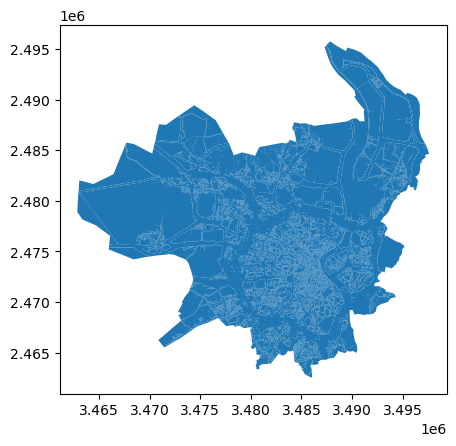

In [12]:
ncm_dis.plot()

In [15]:
uc_city

,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,Batch,geometry
490,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,1.0,"POLYGON ((3487000.000 2464000.000, 3486000.000..."


In [236]:
ncm_agl

,category,agglomerationId_identifier,agglomerationName_nameEng,geometry
0,Lden5559,SE_a_ag0126,Huddinge,"POLYGON ((4784278.612 4041120.822, 4784279.585..."
1,Lden5054,SE_a_ag0126,Huddinge,"MULTIPOLYGON (((4784272.775 4041116.933, 47842..."
2,Lden5559,SE_a_ag0126,Huddinge,"POLYGON ((4784258.519 4040912.418, 4784263.070..."
3,Lden6569,SE_a_ag0126,Huddinge,"POLYGON ((4784488.572 4040881.867, 4784488.892..."
4,Lden6569,SE_a_ag0126,Huddinge,"POLYGON ((4784421.092 4040899.374, 4784420.271..."
...,...,...,...,...
3077,Lden5559,SE_a_ag0126,Huddinge,"POLYGON ((4786101.903 4039775.584, 4786105.477..."
3078,Lden5559,SE_a_ag0126,Huddinge,"POLYGON ((4786108.778 4039692.659, 4786111.452..."
3079,Lden5054,SE_a_ag0126,Huddinge,"POLYGON ((4786151.272 4039784.283, 4786153.264..."
3080,Lden5054,SE_a_ag0126,Huddinge,"POLYGON ((4786169.278 4039779.923, 4786171.856..."


In [252]:
ncm_agl.category.unique()

array(['Lden5559', 'Lden5054', 'Lden6569', 'LdenGreaterThan75',
       'Lden4549', 'Lden4044', 'Lden6064', 'Lden7074', 'LdenLowerThan40'],
      dtype=object)

In [237]:
agl_city

,agglomerationId_identifier,agglomerationName_nameEng,geometry
24,SE_a_ag0126,Huddinge,"MULTIPOLYGON (((4769203.447 4044140.850, 47697..."


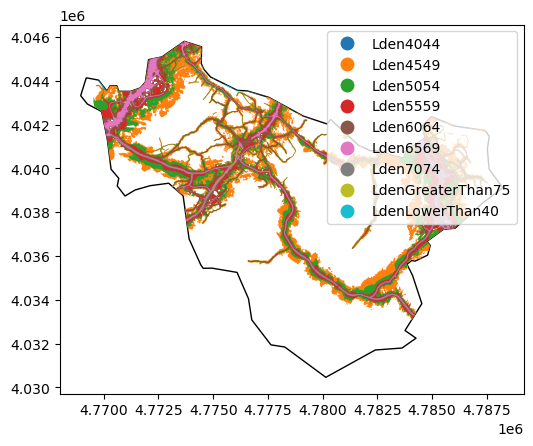

In [254]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load or create your GeoDataFrames


# Plot both GeoDataFrames
fig, ax = plt.subplots()
agl_city.plot(ax=ax, facecolor='none',  label='agglomeration')
ncm_agl.plot(column='category', ax=ax, legend=True, categorical=True, label='ncm')

# Show the plot
plt.show()



In [256]:
try:
    ncm_agl_city = gpd.overlay(agl_city, ncm_agl, how='union')
except:
    print('except')

except


In [251]:
import geopandas as gpd
from shapely.errors import TopologicalError
from shapely.ops import snap

# Function to handle overlay operation with error capture
def process_overlay(gdf1, gdf2, tolerance=0.0001):
    try:
        # Attempt to perform the overlay union operation
        result = gpd.overlay(gdf1, gdf2, how='union')
        print("Operation successful:")
    except TopologicalError as e:
        print("Caught a TopologicalError:", e)
        # Handle the error by snapping geometries to a grid
        gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: snap(geom, gdf2.unary_union, tolerance))
        gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: snap(geom, gdf1.unary_union, tolerance))
        try:
            # Retry the overlay union operation with snapped geometries
            result = gpd.overlay(gdf1, gdf2, how='union')
            print("Operation successful after snapping:")
        except TopologicalError as e:
            print("Caught another TopologicalError after snapping:", e)
            result = None
    return result

# Process the overlay union operation
###result = process_overlay(gdf1, gdf2)
ncm_agl_city = process_overlay(ncm_agl, agl_city)
if ncm_agl_city is not None:
    ncm_agl_city.plot()
else:
    print("Failed to process geometries.")


GEOSException: TopologyException: found non-noded intersection between LINESTRING (4.77197e+06 4.04444e+06, 4.77202e+06 4.04478e+06) and LINESTRING (4.77198e+06 4.04451e+06, 4.77198e+06 4.04451e+06) at 4771984.3173072422 4044514.731865529